# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Вихідний шар
    self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x_1 = self.layer_1(x, activation=0)
    x_2 = self.layer_2(x_1, activation=0)
    x_3 = self.out_layer(x_2, activation=1)


    return x_3

In [ ]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
  acc = tf.metrics.Accuracy()
  acc.update_state(y_true, tf.argmax(y_pred, axis=1))
  return acc.result()

In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradient = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    return optimizer.apply_gradients(zip(gradient, trainable_variables))

In [ ]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)

        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss: {loss}, Accuracy: {acc}")

Step: 100, Loss: 34.765106201171875, Accuracy: 0.9609375
Step: 200, Loss: 47.193382263183594, Accuracy: 0.9609375
Step: 300, Loss: 33.43119812011719, Accuracy: 0.9609375
Step: 400, Loss: 38.24930191040039, Accuracy: 0.94921875
Step: 500, Loss: 25.520662307739258, Accuracy: 0.96875
Step: 600, Loss: 35.033668518066406, Accuracy: 0.97265625
Step: 700, Loss: 29.724822998046875, Accuracy: 0.9765625
Step: 800, Loss: 31.533340454101562, Accuracy: 0.97265625
Step: 900, Loss: 26.25371551513672, Accuracy: 0.97265625
Step: 1000, Loss: 25.512937545776367, Accuracy: 0.96875
Step: 1100, Loss: 20.579282760620117, Accuracy: 0.9765625
Step: 1200, Loss: 19.507299423217773, Accuracy: 0.9765625
Step: 1300, Loss: 31.16244125366211, Accuracy: 0.97265625
Step: 1400, Loss: 32.03863525390625, Accuracy: 0.97265625
Step: 1500, Loss: 34.92204284667969, Accuracy: 0.953125
Step: 1600, Loss: 30.26925277709961, Accuracy: 0.9609375
Step: 1700, Loss: 24.9150390625, Accuracy: 0.97265625
Step: 1800, Loss: 27.500600814819

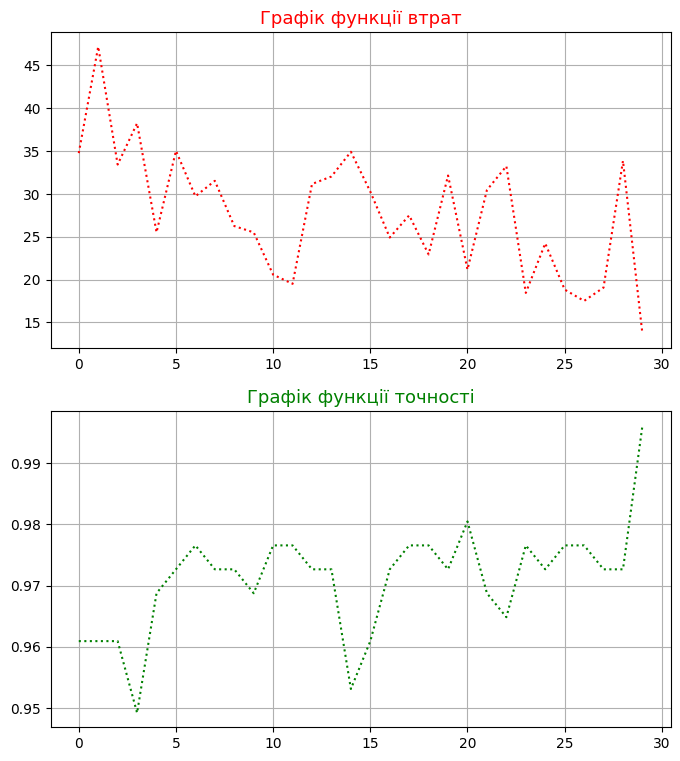

In [ ]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
axs[0].plot(loss_history, "r", label="Loss", linestyle=":")
axs[1].plot(accuracy_history, "g", label="Accuracy", linestyle=":")
axs[0].set_title("Графік функції втрат", fontsize=13, color="r")
axs[1].set_title("Графік функції точності", fontsize=13, color="g")
axs[0].grid()
axs[1].grid()
plt.subplots_adjust(top=1.5)

# Виведіть графік точності
# fig, axs_2 = plt.subplots(figsize=(8, 5))
# axs_2.plot(accuracy_history, "g", label="Accuracy", linestyle=":")
# plt.title("Графік функції точності", fontsize=13, color="g")
# plt.grid()
# plt.show()

In [ ]:
# Обчисліть точність навченої нейромережі
nn_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Neural Net Accuracy: {nn_accuracy}")

Test: 2, Predict: 2
Test: 1, Predict: 1
Test: 6, Predict: 6
Test: 8, Predict: 3
Test: 4, Predict: 4
Test: 4, Predict: 4
Test: 9, Predict: 9
Test: 3, Predict: 3
Test: 1, Predict: 1
Test: 2, Predict: 2


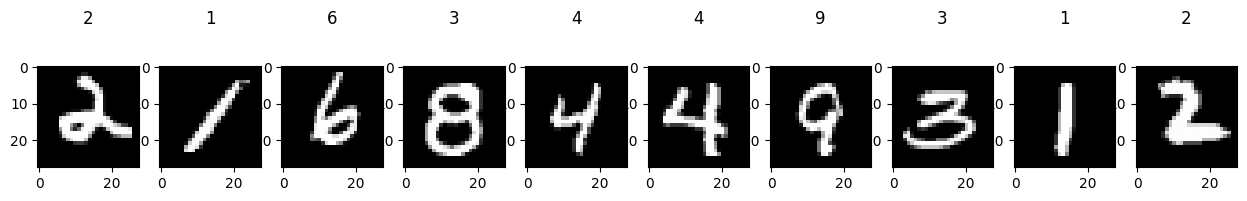

In [53]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

test_images = np.random.permutation(x_test.shape[0])[:10]
y_test_img = y_test[test_images]
pred_img = [np.argmax(x) for x in neural_net(x_test[test_images])]

for i in range(10):
  print(f"Test: {y_test_img[i]}, Predict: {pred_img[i]}")
  plt.subplot(1, 10, (i + 1))
  plt.imshow(x_test[test_images[i]].reshape(28, 28), cmap="gray")
  plt.text(x=12, y=-12, s=pred_img[i], fontsize=12)

plt.subplots_adjust(right=2)
plt.show()

## Висновок:
Загалом, нейромережа працює добре. Іноді бувають випадки помилок і, зазвичай, це відбувається між числами 9 та 4. Також помилки утворюються, коли береш не всі 10 цифр.